In [1004]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import sklearn.datasets


# Linear Regression, K-fold Cross Validation, Gaussian Process Regression and Logistic Regression

In [2]:
def f(X):
    return X + (0.1 * X**2) + (0.05 * X**3) + 10*np.sin(X) 
    
X = np.linspace(-10,10,1000)[:,None]
Y = f(X)

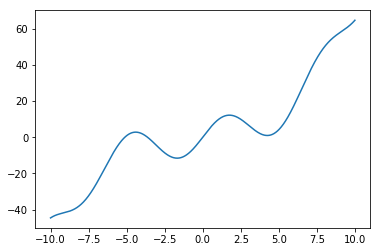

In [3]:
plt.plot(X, Y)
plt.show()

In basic ordinary least squares linear regression, we are given $N$ vectors X_i of dimension $D$ and scalars $Y_i$. (The assumption that $Y_i$ is scalar can be made without loss of generality in the simplest case we are considering here, as if $Y_i$ is multi-dimensional then the problem reduces to separate independent regression problems for each dimension of $Y_i$).

The high-level goal is to find a vector $\alpha$ and scalar $\beta$ such that ${X_i}^{\intercal} \alpha + \beta \approx Y_i$ for all $i$. By writing $\tilde{X_i}^\intercal = [1,  X_i^\intercal]$ and $\tilde{\alpha} = [\beta, \alpha^\intercal]$ we rewrite the problem as trying to find $\tilde{\alpha}$ such that $\tilde{X_i}^{\intercal} \tilde{\alpha}  \approx Y_i$ for all $i$. In the remainder, we will assume that $X_i$ has constant 1 as its first coordinate, and drop the tildes.

We formalise this goal by using the following loss function, corresponding to the average squared difference between target and estimate, writing $X$ for the matrix whose $i$ith row is $X_i$, and $Y$ to be the vector whose $i$th entry is $Y_i$:

$$
\begin{align*}
L(\alpha) &= \frac{1}{N}\sum_i \left( X_i^\intercal \alpha - Y_i \right) \\
          &= \frac{1}{N} \left( X \alpha - Y \right)^\intercal \left( X \alpha - Y \right)
\end{align*}
$$

Taking derivatives with respect to $\alpha$ yields:

$$
\begin{align*}
\frac{dL}{d\alpha} = \frac{1}{N} X^\intercal \left(X \alpha - Y\right)
\end{align*}
$$

Solving for $\frac{dL}{d\alpha} = 0$ gives:

$$
\begin{align*}
0 = X^\intercal X \alpha - X^\intercal Y \quad \implies \quad \alpha = \left(X^\intercal X\right)^{-1} X^\intercal Y
\end{align*}
$$

The following code implements solving for $\alpha$ given input data.

In [4]:
def linear_regression(X, Y):
    # Returns vector of coefficients for linear regression alpha. 
    # alpha[0] is bias / linear intercept, alpha[1:] is slope
    
    # Add column of ones to left side of X
    ones = np.ones([len(X), 1])
    X_tilde = np.concatenate([ones, X], axis=1)
    
    # Solves the equation (X.T * X) alpha = (X.T *Y)
    alpha = np.linalg.solve(X_tilde.T.dot(X_tilde), X_tilde.T.dot(Y))
    return alpha

We can visualise the result of our regression by plotting the estimated targets $Y$ for each input $X$

In [5]:
def linear_estimator(X, alpha, beta):
    return X.dot(alpha) + beta

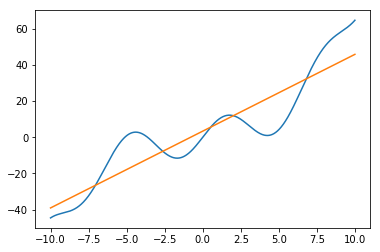

In [6]:
beta, alpha = linear_regression(X, Y)
Y_est = linear_estimator(X, alpha, beta)

plt.plot(X, Y)
plt.plot(X, Y_est)
plt.show()

We can also do regression using more complex basis functions, for instance polynomials. When doing this, we simply augment our data matrix by adding features of the original data as new columns, and then do linear regression as before.

In [11]:
def polynomial_regression(X, Y, D):
    # d is maximal degree of the polynomials to be used
    assert D > 0
    
    # First, add 1s as new column on left of X
    ones = np.ones([len(X), 1])
    X_tilde = np.concatenate([ones, X], axis=1)
    
    # Add new column on right for each polynomial we consider
    for d in range(2,D+1):
        X_tilde = np.concatenate([X_tilde, X_tilde[:,1][:,None]**d], axis=1)
        
    # Solve linear regression in this new space 
    alpha = np.linalg.solve(X_tilde.T.dot(X_tilde), X_tilde.T.dot(Y) )
    return alpha

In [17]:
def poly_estimator(X, poly_alpha):
    # First, add 1s as new column on left of X
    ones = np.ones([len(X), 1])
    X_tilde = np.concatenate([ones, X], axis=1)
    
    # Add new column on right for each polynomial we consider
    for d in range(2,len(poly_alpha)):
        X_tilde = np.concatenate([X_tilde, X_tilde[:,1][:,None]**d], axis=1)
        
    # Calculate expected values for Y    
    Y = X_tilde.dot(poly_alpha)    
    return Y

Observe below that as we change the maximum polynomial degree, we can approximate the true function arbitrarily well.

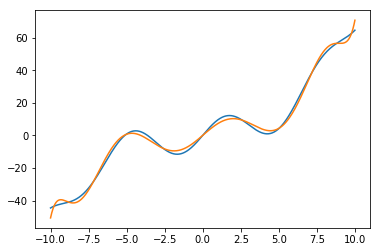

In [28]:
max_polynomial_degree = 10
poly_alpha = polynomial_regression(X, Y, max_polynomial_degree)
Y_poly_est = poly_estimator(X, poly_alpha)

plt.plot(X, Y)
plt.plot(X, Y_poly_est)
plt.show()

# Cross validation

Given a real regression problem, how should we decide what number of features to use in our regression? If we use too many polynomials, we'll overfit to the noise in the data. If we use too few, we'll underfit.

Let's generate some data that we corrupt with noise. The blue dots show the corrupted Y-values, the red dots the true values. When performing regression, we should ideally be aiming to predict the red values, though we don't have access to these.

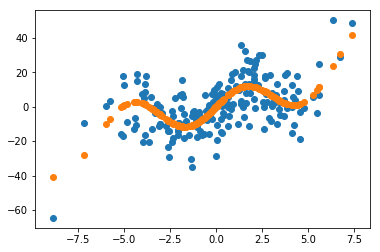

In [105]:
n_data = 200
noise_level = 10

X = 3*np.random.randn(n_data)[:,None]
X = np.sort(X, axis=0)
Y = f(X)
Y_noisy = Y + noise_level * np.random.randn(n_data)[:,None]
plt.scatter(X, Y_noisy)
plt.scatter(X, Y)
plt.show()

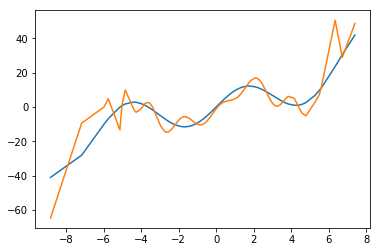

In [106]:
max_polynomial_degree = 100
poly_alpha = polynomial_regression(X, Y_noisy, max_polynomial_degree)
Y_poly_est = poly_estimator(X, poly_alpha)

plt.plot(X, Y)
plt.plot(X, Y_poly_est)
plt.show()

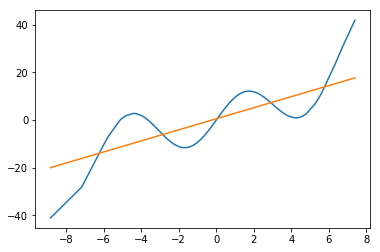

In [107]:
max_polynomial_degree = 1
poly_alpha = polynomial_regression(X, Y_noisy, max_polynomial_degree)
Y_poly_est = poly_estimator(X, poly_alpha)

plt.plot(X, Y)
plt.plot(X, Y_poly_est)
plt.show()

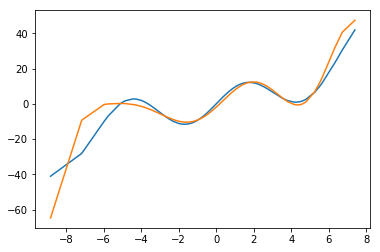

In [112]:
max_polynomial_degree = 10
poly_alpha = polynomial_regression(X, Y_noisy, max_polynomial_degree)
Y_poly_est = poly_estimator(X, poly_alpha)

plt.plot(X, Y)
plt.plot(X, Y_poly_est)
plt.show()

k-fold cross-validation is a method in which we split our data into k parts of equal size. We train our model on k-1 of the parts, and test it with the final part. We do this k times, leaving out each part once, and average our loss over each of these k experiments. This allows us to estimate the true generalisation loss with the proposed choice of hyperparameters. By repeating this for all hyperparameter choices (in our case, the number of polynomials to use) we can estimate which are the best hyperparameters to use.

Below, we implement k-fold cross-validation for polynomial regression.

In [113]:
def mean_squared_error(Y, Y_est):
    return (Y - Y_est).T.dot(Y - Y_est)

In [167]:
def K_fold_cross_validation(X, Y, K, D_max):
    N = len(Y)
    
    # We'll put all of the data together in one big matrix and shuffle the rows to ensure that the k folds are all iid
    data = np.concatenate([X, Y], axis=1)
    np.random.shuffle(data)
    
    # We will keep track of the accumulated losses for each choice of d=1,... D_max in a list
    errors = [0]*(D_max) #errors[d-1] is loss for d
    
    # For each k fold, perform regression and check loss on the held out fold. 
    # Add this result to the error array
    for d in range(1, D_max+1):
        for k in range(K):
            idx_low = int( N * (float(k) / K) )
            idx_high = int( N * (float(k+1) / K) )
            data_hold = data[idx_low: idx_high, :]
            
            X_hold = data_hold[:,0][:,None]
            Y_hold = data_hold[:,1][:,None]
            
            data_fit = np.concatenate([data[0:idx_low, :], data[idx_high:, :]], axis=0)
            X_fit = data_fit[:, 0][:,None]
            Y_fit = data_fit[:, 1][:,None]
            
            poly_alpha = polynomial_regression(X_fit, Y_fit, d)
            Y_est = poly_estimator(X_hold, poly_alpha)
            
            errors[d-1] += mean_squared_error(Y_hold, Y_est)
    
    return errors
    

Now we can perform cross validation to see what the best choice of max polynomial order is!

In [237]:
errors = K_fold_cross_validation(X, Y_noisy, 100, 30)
min(enumerate([ errors[i][0][0] for i in range(30)]), key=lambda x: x[1])

(7, 28915.637607739736)

Our code thinks that 7 is the best choice!

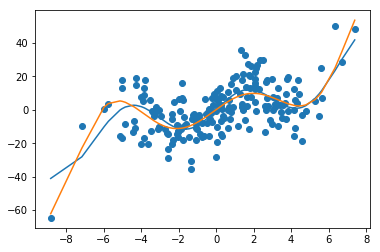

In [238]:
max_polynomial_degree = 7
poly_alpha = polynomial_regression(X, Y_noisy, max_polynomial_degree)
Y_poly_est = poly_estimator(X, poly_alpha)

plt.scatter(X, Y_noisy)
plt.plot(X, Y)
plt.plot(X, Y_poly_est)
plt.show()

Let's now try running this with some real data. We'll use the Mauna Loa CO2 dataset consisting of measurements of atmospheric CO2 concentrations from a station in Hawaii. 

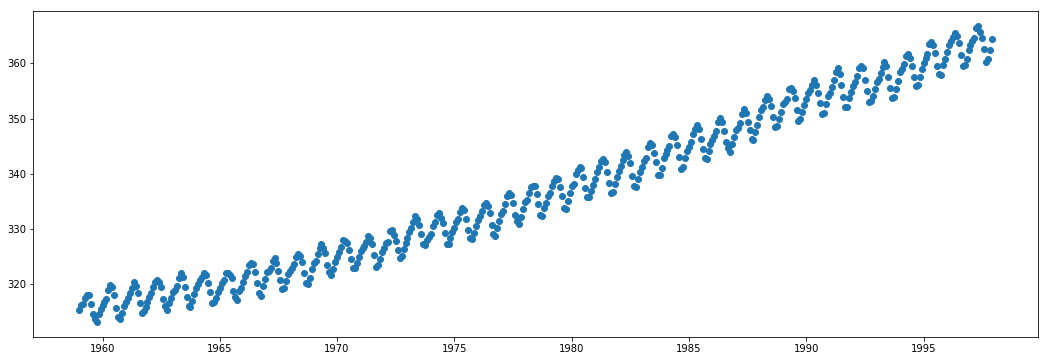

In [339]:
co2 = fetch_mldata('mauna-loa-atmospheric-co2').data
X = co2[:,1][:,None]
Y = co2[:,0][:,None]

plt.figure(figsize=(18,6))
plt.scatter(X,Y)
plt.show()

In [340]:
errors = K_fold_cross_validation(X, Y, 100, 20)
min(enumerate([ errors[i][0][0] for i in range(10)]), key=lambda x: x[1])

(3, 2097.7957413833497)

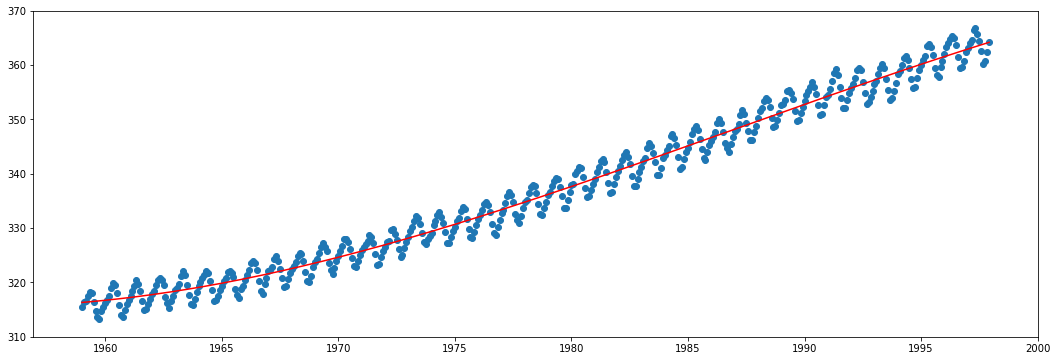

In [341]:
alpha = polynomial_regression(X, Y, 6)
Y_pred = poly_estimator(X, alpha)

plt.figure(figsize=(18,6))
plt.plot(X, Y_pred, c='r')
plt.scatter(X, Y)
plt.show()

This isn't really satisfactory, as we clearly aren't capturing the oscilliatory nature of the relationship in the data. We could try and expand our basis set by including a (finite) choice of clever features, but instead we'll generalise linear regression to the case of infinite features using the 'Kernel Trick'

# The Kernel Trick (Kernel Ridge Regression)

We started this notebook by deriving linear regression. We then said that if we want to use extra features, then we can augment our data matrix by adding extra columns and then performing linear regression with this 'new' data matrix.

Let's consider more generally the application of some feature map $\phi$ to our data. That is, $\phi : x \mapsto \phi(x)$ is a mapping from the original dataspace to some (usually) higher dimensional feature space. We'll write $\Phi$ for the matrix whose $i$th row is $\phi(X_i)^\intercal$.

Adapting the notation from before, we saw that the solution to the linear regression problem when using the feature mapping $\phi$ is

$$
y(x) =  \phi(x)^\intercal \alpha
$$

where $\alpha = (\Phi^\intercal \Phi)^{-1} \Phi^\intercal Y $ minimises

$$
\left(\Phi \alpha - Y \right)^\intercal \left(\Phi \alpha - Y \right)
$$


There are two main problems with this as the dimension of the feature space becomes large.
* We will be prone to overfitting because our model capactiy will increase without any increase in data
* The size of the matrix $\Phi^\intercal \Phi$ will be $d_\phi \times d_\phi$, so inverting (and even storing) this matrix will become problematic when the dimensionality is large.

We can resolve the overfitting problem by adding in regularisation. That is, we solve the problem:

$$
\min:  \left(\Phi \alpha - Y \right)^\intercal \left(\Phi \alpha - Y \right) + \lambda \alpha^\intercal \alpha
$$

The solution to this problem can be found straightforwardly by differentiating wrt $\alpha$ and is 

$$
\alpha = (\lambda I_{d_\phi} + \Phi^\intercal \Phi)^{-1} \Phi^\intercal Y 
$$

The best choice of $\lambda$ can be found using cross validation, as with the polynomial degree earlier. This didn't solve the second problem though.

Fortunately, the so-called "Kernel Trick" can come to our rescue. First, observe that the following identity holds:

$$
(\lambda I_{d_\phi} + \Phi^\intercal \Phi) \Phi^\intercal = \Phi^\intercal (\lambda I_{N} + \Phi \Phi^\intercal ) 
$$

Where $N$ is the number of data. Taking inverses, we see that 

$$
 \Phi^\intercal (\lambda I_{N} + \Phi \Phi^\intercal )^{-1} = (\lambda I_{d_\phi} + \Phi^\intercal \Phi)^{-1} \Phi^\intercal  
$$

and hence we can equivalently write $\alpha$ as

$$
\alpha = \Phi^\intercal (\lambda I_{N} + \Phi \Phi^\intercal )^{-1} Y 
$$

Notice now that the solution to the regression problem can be equivalently written as

$$
y(x) =  \phi(x)^\intercal  \Phi^\intercal (\lambda I_{N} + \Phi \Phi^\intercal )^{-1} Y
$$

This maybe doesn't look that special, but we've solved an important part of our problem above. If $d_\phi >> N$, then we're able to write the solution in a form that does not require inverting a very large matrix. But the most important part of all of this is the following observation: the prediction $y(x)$ can be written purely in terms of inner products of data in the feature space. 

If we write $k(X_i, X_j) = \phi(X_i)^\intercal \phi(X_j)$ and let $K$ be the matrix with entries $K_{ij} = k(X_i, X_j)$, then we can write

$$
y(x) =  [k(x,X_1), k(x,X_2), \ldots, k(x,X_N)] (\lambda I_{N} + K )^{-1} Y
$$

The feature mapping $\phi$ doesn't actually appear explicitly anywhere in this formula. This is the power of the Kernel Trick - as long as there exists a function $k$ giving us dot products between featurised versions of our data, we can use infinitely large feature spaces with finite computational space and time.

We could talk a lot more about kernels and their properties, but we'll save that for another time. Crucial here to us will be that sums of kernels are kernels. We'll use the squared exponential kernel at first, and also maybe the periodic kernel later. See http://www.cs.toronto.edu/~duvenaud/cookbook/ for examples of kernels.

In [342]:
def exponential_kernel(X, Y, params):
    # returns the matrix K of size (len(X), len(Y)) with K_ij = k(X_i, Y_j)
    # X and Y must be d x 1 np.arrays
    var, length = params
    K = var * np.exp(-((X - Y.T)**2)/(2 * length**2))
    return K

We can now do kernel ridge regression. The following function returns a function which gives the prediction at any desired input.

In [362]:
def kernel_ridge_regression(X, Y, kernel, kernel_params, lam):
    K = kernel(X, X, kernel_params)
    prod = (np.linalg.inv(lam*np.identity(len(X)) + K)).dot(Y)
    return lambda Z: kernel(Z, X, kernel_params).dot(prod)

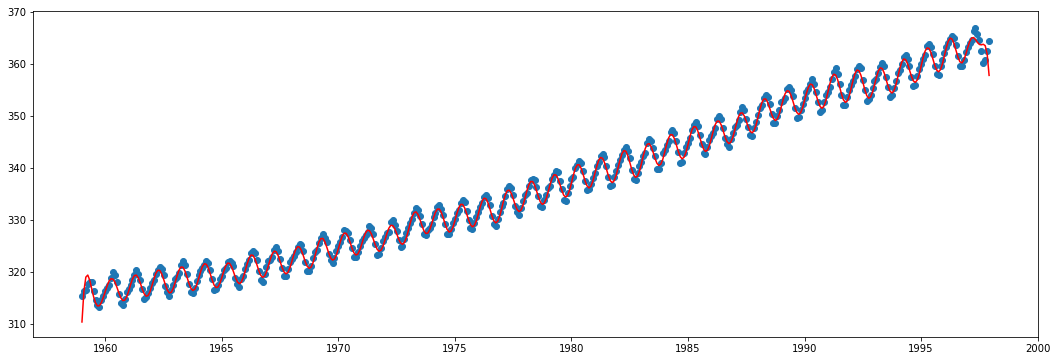

In [363]:
f = kernel_ridge_regression(X, Y, exponential_kernel, [10,0.5], 0.1)

plt.figure(figsize=(18,6))
plt.plot(X, f(X), c='r')
plt.scatter(X, Y)
plt.show()

This appears to be doing something better than the plain linear regression before. Perhaps this isn't surprising - we have infinitely many features now rather than finitely many! However, let's see what our learned function thinks is happening outside of the range of data we've seen.

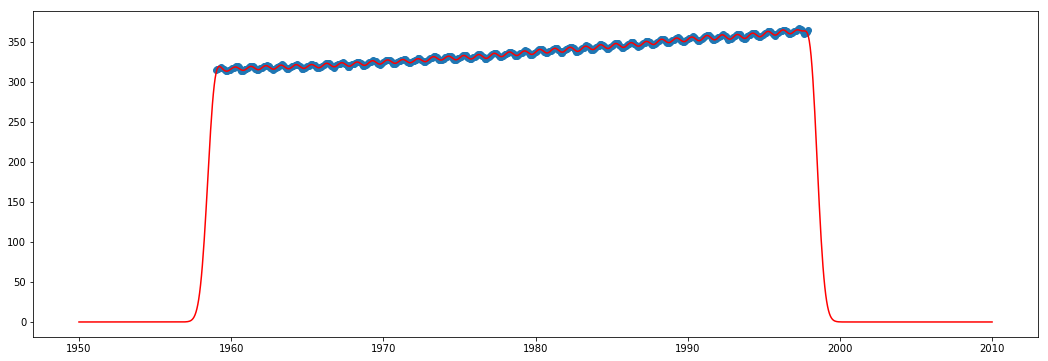

In [365]:
plt.figure(figsize=(18,6))
inputs = np.linspace(1950,2010,1000)[:,None]
plt.plot(inputs, f(inputs), c='r')
plt.scatter(X, Y)
plt.show()

Clearly the model has learned to interpolate fairly well, but is completely failing to extrapolate. We can fix this by using a more flexible choice of kernel.

In [366]:
def periodic_kernel(X, Y, params):
    # returns the matrix K of size (len(X), len(Y)) with K_ij = k(X_i, Y_j)
    # X and Y must be d x 1 np.arrays
    var, period, length = params
    K = var * np.exp(-(2*(np.sin(np.pi*np.abs(X - Y.T)/period)**2))/(length**2))
    return K

In [396]:
def linear_kernel(X, Y, params):
    # returns the matrix K of size (len(X), len(Y)) with K_ij = k(X_i, Y_j)
    # X and Y must be d x 1 np.arrays
    var, bias, center = params
    K = bias*np.ones([len(X), len(Y)]) + var * (X - center).dot((Y-center).T)
    return K

In [397]:
len(X)

468

In [398]:
def per_exp_lin_kernel(X, Y, params):
    # params is a list of lists: params[0] are parameters of periodic component, params[1] for exp, params[2] for lin
    return (periodic_kernel(X, Y, params[0]) + exponential_kernel(X, Y, params[1]) + linear_kernel(X, Y, params[2]))

In [399]:
parameters = [
    [1, 1, 1],  # periodic kernel parameters: var, period, length
    [1, 1],  # exponential kernel parameters: var, length
    [1, 1, X.mean()]   # linear kernel parameters: var, bias, center
]

lam = 0.1

f = kernel_ridge_regression(X, Y, per_exp_lin_kernel, parameters, lam)

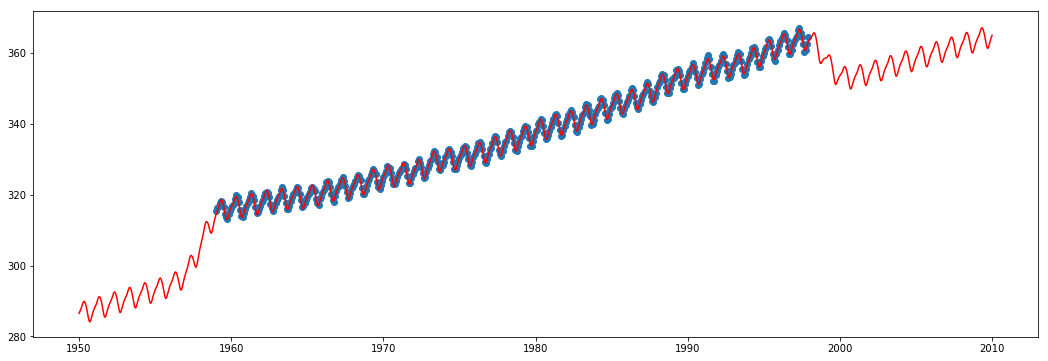

In [400]:
plt.figure(figsize=(18,6))
inputs = np.linspace(1950,2010,1000)[:,None]
plt.plot(inputs, f(inputs), c='r')
plt.scatter(X, Y)
plt.show()

Even with a pretty much random initial choice for the hyperparameters, this is already looking much better (note however that there is a yearly period and we chose 1 as the period hyperparameter, so that is an important one we got right already). We could find better hyperparameters in a couple of different ways. 

We could do grid-search over the hyperparameters using the losses from k-fold cross validation as the objective function. 

Or we could hold out some of the data - say, the last 10 years rather than a random subset since we want to extrapolate well - and perform gradient based optimisation of this objective with respect to the hyperparameters.

We're not going to do either of these here. After trying a few different combinations of parameters and evaluating the fit "by eye", you can see that the following parameters are better than the first ones above.

In [544]:
parameters = [
    [5, 1, 1],  # periodic kernel parameters: var, period, length
    [1, 10],  # exponential kernel parameters: var, length
    [10, 10, X.mean()]   # linear kernel parameters: var, bias, center
]

lam = 0.1

f = kernel_ridge_regression(X, Y, per_exp_lin_kernel, parameters, lam)

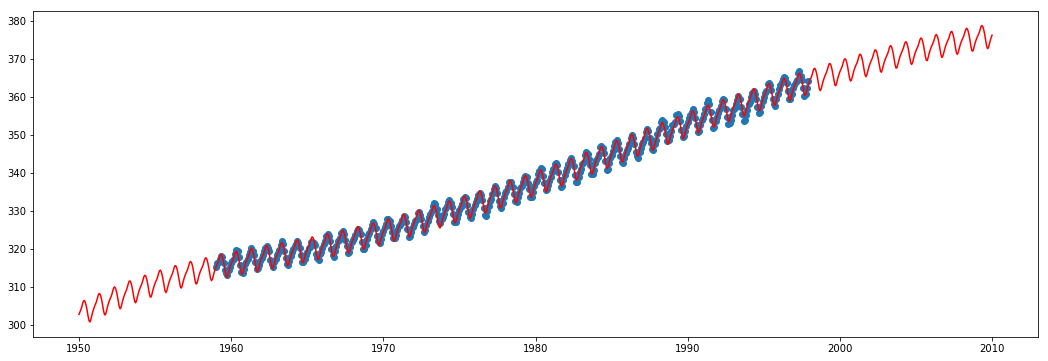

In [545]:
plt.figure(figsize=(18,6))
inputs = np.linspace(1950,2010,1000)[:,None]
plt.plot(inputs, f(inputs), c='r')
plt.scatter(X, Y)
plt.show()

# Gaussian Process Regression

Gaussian processes are defined as families of random variables indexed by some set (usually $\mathbb{R}^d$), any finite subset of which is jointly Gaussian. A Gaussian process is fully specified by two things: a kernel function and a mean function. Gaussian Processes are very closely related to Kernel Ridge Regression. We'll assume here that we're always regressing here from $\mathbb{R}^d$ to $\mathbb{R}$.

If we wish to put a Gaussian Process prior over a function $f$, we write 

$$
f \sim \mathcal{GP}\left(\mu, k \right)
$$

where $\mu: \mathbb{R}^d \to \mathbb{R}$ is the mean function and  $k: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$ is the kernel (positive semi-definite) function that determines how different values $f(x_i)$ and $f(x_j)$ are correlated.

For simplicity, we'll assume in the rest of this that $\mu$ is the zero function.

If we're interested in considering the prior values of $f$ at a particular set of inputs $X_1, \ldots, X_N$, we can calculate this as a multivariate Gaussian:

$$
\begin{pmatrix} 
f(X_1) \\
\vdots \\
f(X_N)
\end{pmatrix} \sim \mathcal{N}\left( 0, K\right) 
$$

where $K$ is the matrix with entries $K_{ij} = k(X_i, X_j)$

Let's suppose we've observed that $f(X_i) = Y_i$ at each of the points $X_i$, and we're interested in the posterior over $f(X_*)$ at some new point $X_*$. The prior distribution over these $N+1$ points would be

$$
\begin{pmatrix} 
f(X_*) \\
f(X_1) \\
\vdots \\
f(X_N)
\end{pmatrix} \sim \mathcal{N}\left( 0, 
\begin{pmatrix} 
k_{**} & K_*^\intercal \\
K_* & K
\end{pmatrix}\right) 
$$

where $k_{**} = k(X_*, X_*)$ and $K_* = \begin{pmatrix} 
k(X_*, X_1) \\
k(X_*, X_2) \\
\vdots \\
k(X_*, X_N)
\end{pmatrix}$

Thus, finding the posterior over $f(X_*)$ amounts to just conditioning a multivariate Gaussian. This results in

$$
f(X_*) \sim \mathcal{N}\left(K_*^\intercal K^{-1} Y, \quad k_{**} - K_*^\intercal K^{-1} K_* \right)
$$


Note that the mean here is the same as for Kernel Ridge Regression! Well, nearly - we should really use the kernel $\tilde{k} = k + \lambda\mathbb{1}_{x=x'}$ 

In [590]:
def GP_regression(X, Y, kernel, parameters, lam):
    K = kernel(X, X, parameters) + np.identity(len(X))*lam
    posterior_mean = lambda Z: kernel(Z, X, parameters).dot(np.linalg.inv(K).dot(Y))
    posterior_cov = lambda Z: (kernel(Z, Z, parameters) - kernel(Z, X, parameters).dot(np.linalg.inv(K).dot(kernel(X, Z, parameters))))
    return posterior_mean, posterior_cov
    

In [591]:
f_m, f_c = GP_regression(X, Y, exponential_kernel, [10,0.1], 0.01)

Let's see the results of our regression. In the next plot, we zoom in on a small section of the data so that we can see our nice confidence intervals.

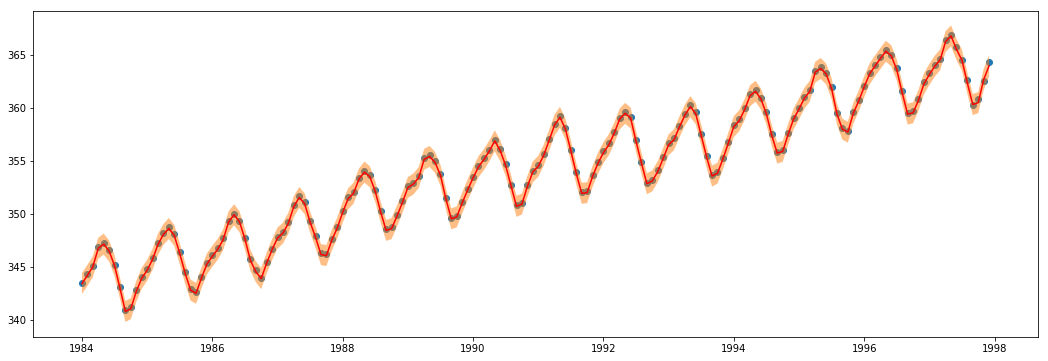

In [592]:
inputs = X[300:]
m = f_m(inputs)
var = np.diag(f_c(inputs))[:,None]
std = np.sqrt(var)

plt.figure(figsize=(18,6))
plt.plot(inputs, m, c='r')
plt.scatter(inputs, Y[300:])
plt.fill_between(inputs[:,0], (m - 10*std)[:,0], (m + 10*std)[:,0], alpha=0.5)
plt.show()

We can do GP regression with the same kernel and parameters as we used before for the better version of Kernel Ridge Regression using the sum of the linear, exponential and periodic kernels. This looks a lot better!

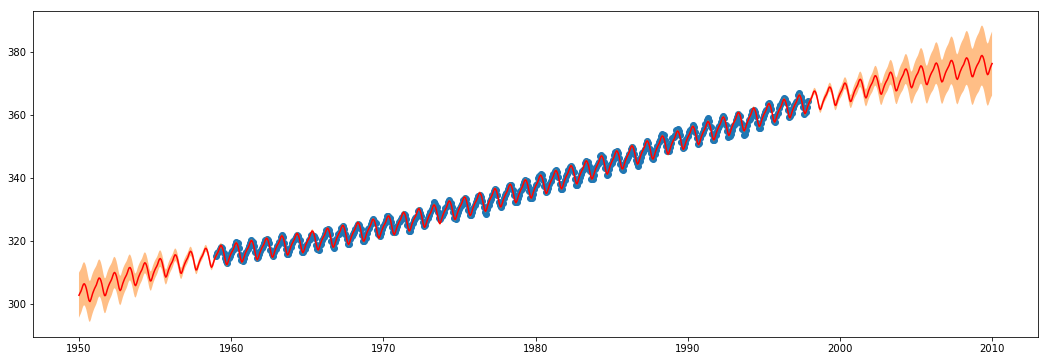

In [611]:
parameters = [
    [5, 1, 1],  # periodic kernel parameters: var, period, length
    [1, 10],  # exponential kernel parameters: var, length
    [10, 10, X.mean()]   # linear kernel parameters: var, bias, center
]

lam = 0.1

f_m, f_c = GP_regression(X, Y, per_exp_lin_kernel, parameters, lam)

inputs = np.linspace(1950,2010,1000)[:,None]
m = f_m(inputs)
var = np.diag(f_c(inputs))[:,None]
std = np.sqrt(var)

plt.figure(figsize=(18,6))
plt.plot(inputs, m, c='r')
plt.scatter(X, Y)
plt.fill_between(inputs[:,0], (m - 10*std)[:,0], (m + 10*std)[:,0], alpha=0.5)
plt.show()

## The Marginal Likelihood
One of the benefits of using GPs is that there is a natural measure of goodness of fit in the marginal likelihood, which is also very easy to evaluate. The likelihood of the data is just the likelihood of the data under the corresponding Gaussian model we get from looking at the prior function values at the given inputs. 

For example, if we observe $f$ at inputs $X_1, \ldots, X_N$, then since the prior over these values is

$$
\begin{pmatrix} 
f(X_1) \\
\vdots \\
f(X_N)
\end{pmatrix} \sim \mathcal{N}\left( 0, K\right) 
$$

the marginal log-likelihood is simply 

$$
\begin{align*}
LL &= \log \left( \frac{1}{\det\left( 2\pi K\right)^{1/2}} \exp\left(\frac{-1}{2} f(X)^\intercal K^{-1} f(X)\right)\right) \\
&= \frac{-1}{2} f(X)^\intercal K^{-1} f(X) - \frac{1}{2}\log\det(K) - \frac{N}{2}\log(2\pi)
\end{align*}
$$


In [598]:
def GP_marg_ll(X, Y, kernel, parameters, lam):
    K = kernel(X, X, parameters)
    K = K + np.identity(len(X)) * lam
    (sign, logdet) = np.linalg.slogdet(K)
    mll = 1./2 * (- Y.T.dot(np.linalg.inv(K)).dot(Y) - sign*logdet - len(X)*np.log(2*np.pi))
    return mll

Using this function we now have an objective function with respect to which we can optimise in order to improve fit. Below are some better parameters that were found by hand.

[[-442.93980099]]


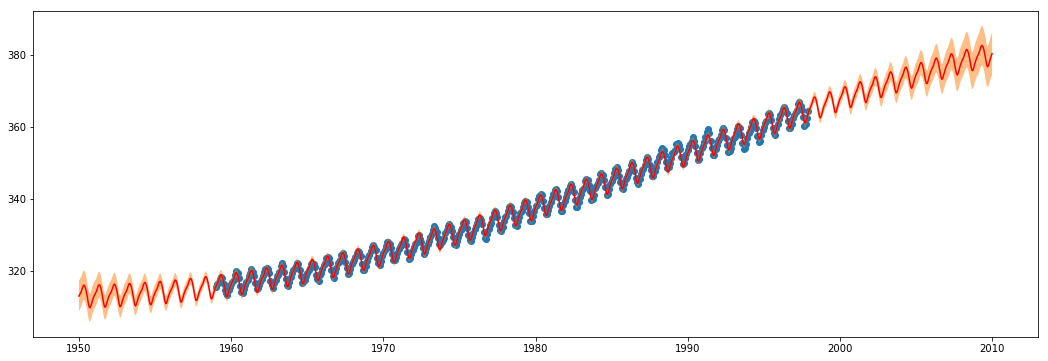

In [661]:
parameters = [
    [10, 1, 1],  # periodic kernel parameters: var, period, length
    [100, 50],  # exponential kernel parameters: var, length
    [10, 100000, X.mean()]   # linear kernel parameters: var, bias, center
]

lam = 0.4

print GP_marg_ll(X, Y, per_exp_lin_kernel, parameters, lam)

f_m, f_c = GP_regression(X, Y, per_exp_lin_kernel, parameters, lam)

inputs = np.linspace(1950,2010,1000)[:,None]
m = f_m(inputs)
var = np.diag(f_c(inputs))[:,None]
std = np.sqrt(var)

plt.figure(figsize=(18,6))
plt.plot(inputs, m, c='r')
plt.scatter(X, Y)
plt.fill_between(inputs[:,0], (m - 10*std)[:,0], (m + 10*std)[:,0], alpha=0.5)
plt.show()

## Logistic Regression

So far we have looked at regression - predicting a real number for each input. We'll now turn our attention to classification. We'll study logistic regression.

The most basic logistic regression model is a discriminative model to predict a binary label $y \in \{0,1\}$ given an input $x$. The model is

$$
p(y | x) = Ber\left
(y | \sigma(w^\intercal x) \right)
$$

where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the sigmoid function. This function is rotationally symmetric about (0,0.5) and tends to 0 as $z\to -\infty$ and 1 as $z \to \infty$. Let's quickly visualise this:

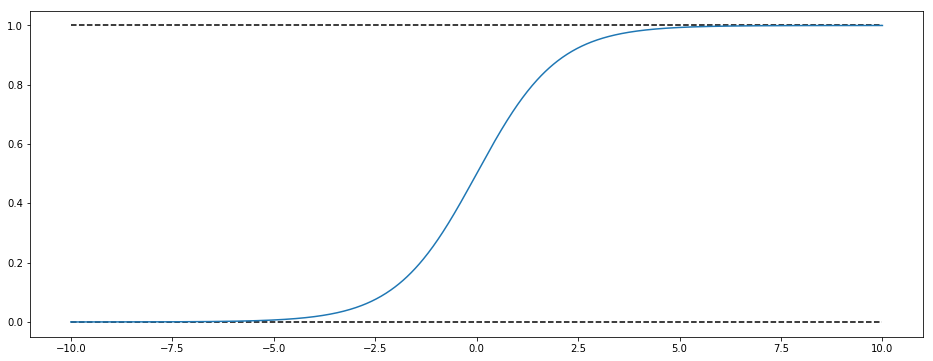

In [857]:
def sigmoid(z):
    # for numerical stability, manually set output for the values of z that are too high or too low
    id_low = z<-50
    id_high = z>50
    z[id_low] = -50
    z[id_high] = 50
    output = 1/(1 + np.exp(-z))
    output[id_high] = 1.
    output[id_low] = 0.
    return output

bound = 10
z = np.linspace(-bound,bound,1000)
plt.figure(figsize=(16,6))
plt.plot(z, sigmoid(z))
plt.hlines(xmin=-bound, xmax=bound, y=1.0, linestyles='--')
plt.hlines(xmin=-bound, xmax=bound, y=0.0, linestyles='--')
plt.show()

Thus we have more explicitly that the probability distribution implied by this model over $y$ given an input $x$ is

$$
p(y | x) = \mathbb{1}_{\{y=0\}} \left[ \frac{1}{1+\exp(w^\intercal x)} \right] + \mathbb{1}_{\{y=1\}} \left[ \frac{1}{1+\exp(-w^\intercal x)} \right]
$$

If we instead write $y \in \{-1, 1\}$ we get

$$
p(y | x) = \frac{1}{1+\exp(-yw^\intercal x)} 
$$

And thus given some data $(x_i, y_i)$ we have that the marginal log-likelihood is

$$
LL = - \sum_i \log\left( 1 + \exp(-y_i w^\intercal x_i ) \right)
$$



The derivative of this with respect to $w$ is

$$
\begin{align*}
\frac{dLL}{dw} &= - \sum_i \left( \frac{-y_i x_i \exp(-y_i w^\intercal x_i )}{ 1 + \exp(-y_i w^\intercal x_i ) } \right) \\
               &= - \sum_i \left( \frac{-y_i x_i }{ 1 + \exp(y_i w^\intercal x_i ) } \right) \\
               &=  \sum_i \left( \frac{y_i x_i }{ 1 + \exp(y_i w^\intercal x_i ) } \right) \\
\end{align*} 
$$

Noting also that 

$$
\sigma(z) = \frac{1}{1 + \exp(-z)}
$$

we see that

$$
\begin{align*}
\frac{d\sigma}{dz}(z) &= \frac{\exp(-z)}{\left(1 + \exp(-z)\right)^2} \\
&= \frac{1}{1 + \exp(-z)} \left(\frac{1 + \exp(-z)}{1 + \exp(-z)}  - \frac{1 }{1 + \exp(-z)} \right)\\
&= \sigma(z) \left( 1 - \sigma(z)\right)
\end{align*}
$$

And hence we can rewrite the stuff above more concisely:

$$
p(y|x) = \sigma(y w^\intercal x)
$$

$$
LL =  \sum_i \log\left(\sigma(y_i w^\intercal x_i) \right)
$$

$$
\begin{align*}
\frac{dLL}{dw} &=  \sum_i \frac{y_i x_i \sigma(y_i w^\intercal x_i) \left(1 - \sigma(y_i w^\intercal x_i) \right) }{\sigma(y_i w^\intercal x_i)} \\
&=  \sum_i y_i x_i  \left(1 - \sigma(y_i w^\intercal x_i) \right) \\
&=  \sum_i y_i x_i  \sigma(-y_i w^\intercal x_i) 
\end{align*}
$$

In [1061]:
def binary_cross_entropy_loss(X, Y, w):
    return (np.log(sigmoid(Y*(X.dot(w))))).sum()

def binary_cross_entropy_gradient(X, Y, w):
    return (Y * X * (sigmoid(-Y*X.dot(w)))).sum(axis=0)[:,None]

def logistic_regression(X, Y):
    w = np.zeros(len(X[0]))[:,None]
    w_old = w
    w = w + binary_cross_entropy_gradient(X, Y, w)
    step_size = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    for i in range(len(step_size)):
        for _ in range(10000):
            w_old = w
            w = w + step_size[i] * binary_cross_entropy_gradient(X, Y, w)
    return w

-27.7258872224
[[ 102.56410259]]
-7.58104690136e-12


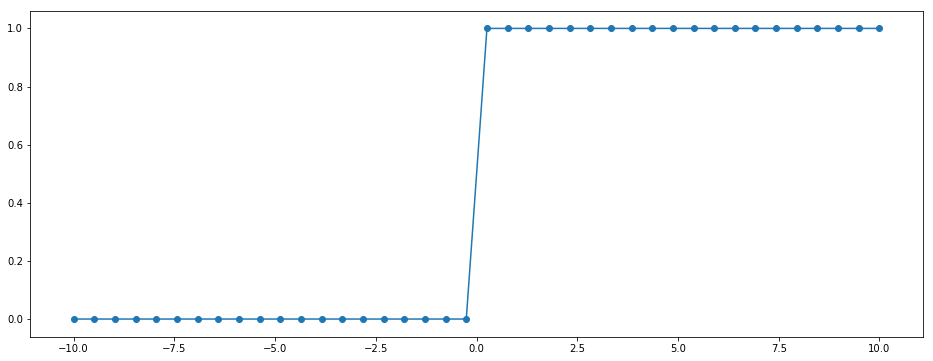

In [1062]:
X = np.linspace(-10,10,40)[:,None]
Y = np.concatenate([-np.ones([20,1]), np.ones([20,1])], axis=0)
w = np.array([[0]])

print binary_cross_entropy_loss(X, Y, w)
w = logistic_regression(X, Y)
print w
print binary_cross_entropy_loss(X, Y, w)

plt.figure(figsize=(16,6))
plt.plot(X, sigmoid(X.dot(w)))
plt.scatter(X,(Y/2 + 1./2))
plt.show()

-27.7258872224
[[ 0.49955037]]
-12.512362691


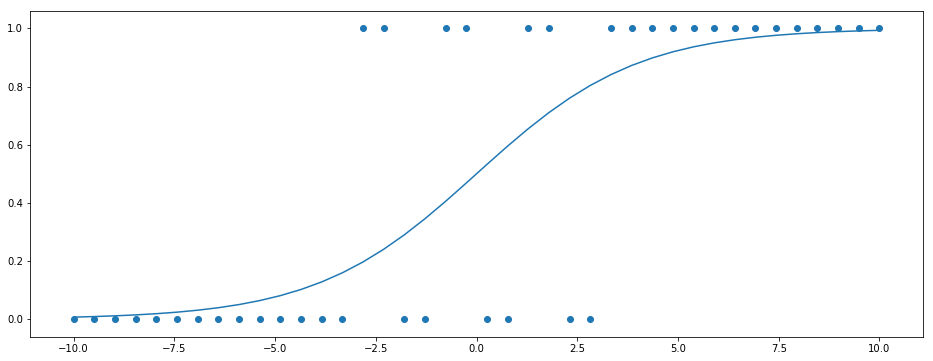

In [1063]:
X = np.linspace(-10,10,40)[:,None]
Y = np.concatenate([-np.ones([10,1]), -np.ones([2,1]), -np.ones([2,1]), np.ones([2,1]), -np.ones([2,1]), 
                    np.ones([2,1]), -np.ones([2,1]), np.ones([2,1]), -np.ones([2,1]), np.ones([2,1]), 
                    np.ones([2,1]), np.ones([10,1])], axis=0)
#Y = np.concatenate([-np.ones([15,1]), np.ones([5,1]), -np.ones([5,1]), np.ones([15,1])], axis=0)
w = np.array([[0]])

print binary_cross_entropy_loss(X, Y, w)
w = logistic_regression(X, Y)
print w
print binary_cross_entropy_loss(X, Y, w)

plt.figure(figsize=(16,6))
plt.plot(X, sigmoid(X.dot(w)))
plt.scatter(X,(Y/2 + 1./2))
plt.show()

In [1064]:
print w
print binary_cross_entropy_loss(X, Y, w)

[[ 0.49955037]]
-12.512362691


In [1065]:
def polyfy(X, D):
    # adds columns to matrix X of polynomial features
    N = len(X)
    X_poly = np.ones([N,1])
    for d in range(1,D+1):
        X_poly = np.concatenate([X_poly, (X**d)], axis=1)
    return X_poly

[[  2.90284935e+00]
 [ -2.63556676e-16]
 [ -1.54122401e-01]]
-10.4610956756


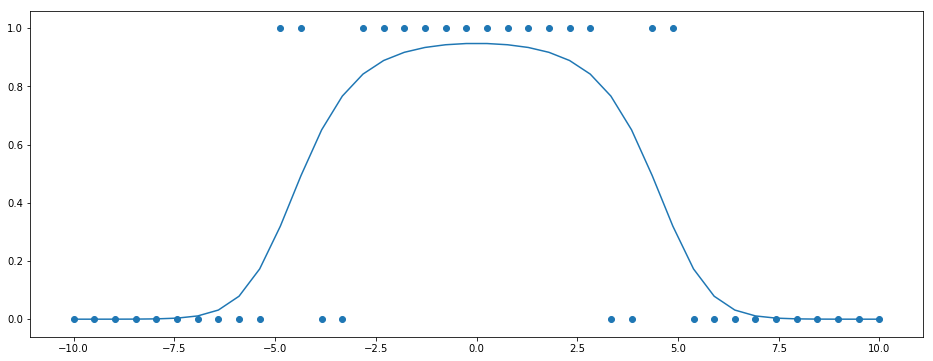

In [1066]:
X = np.linspace(-10,10,40)[:,None]
Y = np.concatenate([-np.ones([10,1]), np.ones([2,1]), -np.ones([2,1]), np.ones([12,1]),
                    -np.ones([2,1]), np.ones([2,1]), -np.ones([10,1])], axis=0)


X_poly = polyfy(X, 2)

w = logistic_regression(X_poly, Y)
print w
print binary_cross_entropy_loss(X_poly, Y, w)

plt.figure(figsize=(16,6))
plt.plot(X, sigmoid(X_poly.dot(w)))
plt.scatter(X,(Y/2 + 1./2))
plt.show()

Let's use a bit of code from `sklearn` to generate some data to do classification on.

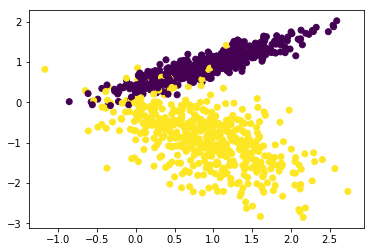

In [1090]:
X, Y= sklearn.datasets.make_classification(n_classes=2, class_sep=0.9,
                                           n_samples=1000, 
                                           n_features=2,
                                           n_redundant=0, 
                                           n_informative=2, 
                                           n_clusters_per_class=1,)

# Make Y into an Nx1 array (rather than vector) and set the 0 entries to -1.
Y = Y[:, None]
Y[Y==0] = -1

# Visualise the data
plt.scatter(X[:,0], X[:,1] , c=Y)
plt.show()

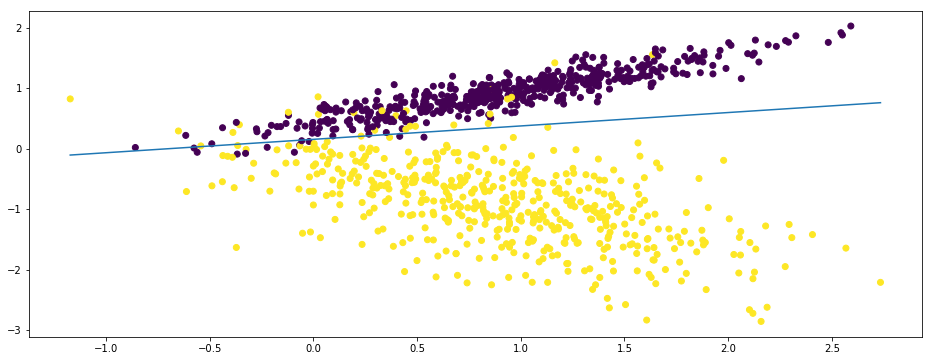

In [1091]:
w = logistic_regression(np.concatenate([np.ones([len(X),1]), X], axis=1), Y)

plt.figure(figsize=(16,6))
plt.scatter(X[:,0], X[:,1] , c=Y)

plotcoords = np.linspace(min(X[:,0]), max(X[:,0]), 1000)

# plot line perpendicular to w: want x satisfying (w[0], w[1], w[2]).dot((1, x[1], x[2])) = 0
# ie x[2] = -(w[0] + w[1]*x[1]) / w[2]

plt.plot(plotcoords, -(w[0] + (w[1]*plotcoords))/w[2])
plt.show()

# Multiclass logistic regression

In the problem of simple binary classification, our model for $p(y|x)$ was as a bernoulli random variable $Ber\left( \sigma( w^\intercal x)\right)$.

In the multiclass setting with $C$ classes, we'll say that $p(y | x)$ is a categorical random variable (multiclass generalisation of bernoulli variables) with parameter $\pi_c \propto \exp(w_c^\intercal x)$. That is,

$$
p(y = c \ |\  x) = \frac{\exp(w_c^\intercal x)}{ \sum_{c'} \exp(w_{c'}^\intercal x)}
$$

The operation mapping $\left(w_1^\intercal x, \ldots, w_C^\intercal\right) \mapsto \left(\exp(w_1^\intercal x), \ldots, \exp(w_C^\intercal x)\right)$ is known as a _softmax_.

The above formulation is indeed a generalisation of the binary case. Indeed, consider that $C=2$. Then

$$
\begin{align*}
p(y = 0 \ |\  x) &= \frac{\exp(w_0^\intercal x)}{\exp(w_0^\intercal x) + \exp(w_1^\intercal x)} \\
                 &= \frac{1}{1 + \exp((w_1-w_0)^\intercal x)} \\
\end{align*}
$$

and

$$
\begin{align*}
p(y = 1 \ |\  x) &= \frac{\exp(w_1^\intercal x)}{\exp(w_0^\intercal x) + \exp(w_1^\intercal x)}\\
                 &= \frac{1}{1 + \exp((w_0-w_1)^\intercal x)} \\
\end{align*}
$$

Given data $(x_i, y_i)$ where each $y_i$ equals some $c \in \{1, \ldots, C\}$, we can rewrite each $y_i$ as a _one hot_ vector of length C, with a one in position $c$ and zeros everywhere else. We write $y_{ij} = 0$ if $y_i \not= c_j$, and $y_{ij} = 1$ if $y_i = c_j$.

The marginal log likelihood can then be written:

$$
\begin{align*}
LL &= \sum_i \log\left( \frac{\sum_{c}\exp(y_{ic}w_{c}^\intercal x_i)}{ \sum_{c} \exp(w_{c}^\intercal x_i)} \right) \\
   &= \sum_i \left( \sum_{c}y_{ic} w_{c}^\intercal x_i - \log\left( \sum_{c} \exp(w_{c}^\intercal x_i)\right)\right) \\
\end{align*}
$$

Where cancelling of the $\log$ and $\exp$ is justified because only one of the terms in the sum is non-zero.

Differentiating with respect to $w_{c'}$ yields

$$
\frac{dLL}{dw_{c'}} = \sum_i \left(  y_{ic'} x_i  - \left( \frac{x_i \exp(w_{c'}^\intercal x_i)}{\sum_{c} \exp(w_c^\intercal x_i)} \right) \right)
$$

We can think of the vectors $w_c$ concatenated into a big matrix $W$ with entries

$$
W_{cs} = (w_{c})_s
$$

If we also write $X$ to be the data matrix with entries $X_{is} = (x_i)_s$  Then we have that 

$$
\frac{dLL}{dW_{cs}} = \sum_i \left(y_{ic} X_{is}  - \left( \frac{X_{is} \exp(\sum_s W_{cs}X_{is})}{\sum_{c'} \exp(\sum_{s} W_{c's} X_{is})} \right) \right)
$$

And the marginal log likelihood can be written

$$
\begin{align*}
LL &= \sum_i \left( \sum_{c,s} y_{ic} W_{cs} X_{is} - \log\left( \sum_{c,s} \exp(W_{cs} X_{is})\right)\right) \\
\end{align*}
$$


In [1376]:
def multivariate_logistic_regression_mll(X, Y, W):
    # Y is one-hot encoded
    # Y[i,c] = 1 if Y_i belongs to class C, =0 otherwise
    XW = X.dot(W.T) # dimension NxC 
    LL = ((Y*XW).sum(axis=1) - np.log( np.exp(XW).sum(axis=1)) ).sum()
    return LL
    
def multivariate_logistic_regression_gradient(X, Y, W):
    # Y is one-hot encoded
    # Y[i,c] = 1 if Y_i belongs to class C, =0 otherwise
    XW = X.dot(W.T) # dimension NxC 
    denom = np.exp(XW).sum(axis=1)[:,None] # Nx1
    num = np.exp(XW)
    dW = (Y - num/denom).T.dot(X)
    return dW

def multivariate_logistic_regression_classifier(W):
    # W is CxD
    # X will be NxD
    # output should be NxC, where rows sum to 1
    C = len(W)
    D = len(W[0])
    fn = lambda X: np.exp(X.dot(W.T))/(np.exp(X.dot(W.T)).sum(axis=1)[:,None])
    return fn

In [1298]:
def multivariate_logistic_regression(X, Y):
    # Finds good parameters W by starting with zero matrix (added random noise in case of symmetry) and optimising
    # by gradient descent.
    N = len(Y)
    C = len(Y[0])
    D = len(X[0])
    w = np.zeros([C,D]) + 0.0001*np.random.randn(C,D)

    step_size = [0.0001, 0.00001, 0.000001]
    for i in range(len(step_size)):
        for _ in range(10000):
            w = w + step_size[i] * multivariate_logistic_regression_gradient(X, Y, w)
    return w

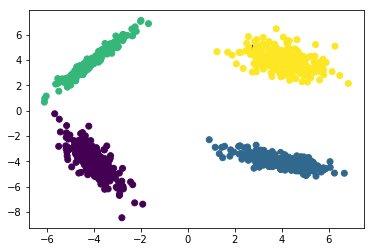

-35.3594617964
[[-0.90333385 -0.83608979]
 [ 0.84610799 -0.88799475]
 [-0.86069756  0.90149758]
 [ 0.91849664  0.82277544]]


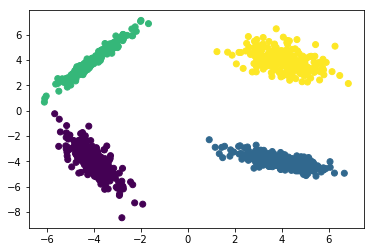

In [1399]:
n_classes = 4
X, Y= sklearn.datasets.make_classification(n_classes=n_classes, class_sep=4,
                                           n_samples=1000, 
                                           n_features=2,
                                           n_redundant=0, 
                                           n_informative=2, 
                                           n_clusters_per_class=1,)

# Make Y into an Nx1 array (rather than vector) and set the 0 entries to -1.
Y_one_hot = np.zeros([len(X), n_classes])
for c in range(n_classes):
    Y_one_hot[Y==c ,c] = 1

# Visualise the data
plt.scatter(X[:,0], X[:,1] , c=Y)
plt.show()

W = multivariate_logistic_regression(X, Y_one_hot)
print multivariate_logistic_regression_mll(X, Y_one_hot, W)
print W
clf = multivariate_logistic_regression_classifier(W)
classes = clf(X).argmax(axis=1)

plt.scatter(X[:,0], X[:,1] , c=classes)
plt.show()


The plot above shows the true clusters of the data. Below we see how we cluster them after doing logistic regression. We succeeded! This was easy though because the clusters are clearly separated.

Now let's try again with the clusters not separated

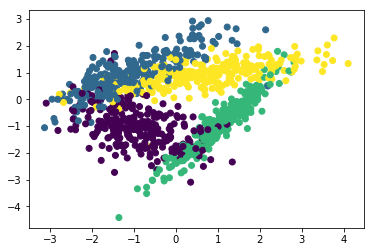

-542.234517369
[[-0.86722004 -2.17892469]
 [-1.1424472   2.38426622]
 [ 1.76888897 -2.29917818]
 [ 0.24062477  2.09325373]]


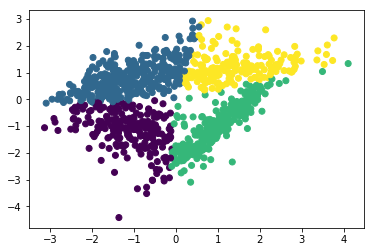

In [1397]:
n_classes = 4
X, Y= sklearn.datasets.make_classification(n_classes=n_classes, class_sep=1,
                                           n_samples=1000, 
                                           n_features=2,
                                           n_redundant=0, 
                                           n_informative=2, 
                                           n_clusters_per_class=1,)

# Make Y into an Nx1 array (rather than vector) and set the 0 entries to -1.
Y_one_hot = np.zeros([len(X), n_classes])
for c in range(n_classes):
    Y_one_hot[Y==c ,c] = 1

# Visualise the data
plt.scatter(X[:,0], X[:,1] , c=Y)
plt.show()



W = multivariate_logistic_regression(X, Y_one_hot)
print multivariate_logistic_regression_mll(X, Y_one_hot, W)
print W
clf = multivariate_logistic_regression_classifier(W)
classes = clf(X).argmax(axis=1)

plt.scatter(X[:,0], X[:,1] , c=classes)
plt.show()

We see in the bottom plot above that we do roughly learn to separate the classes, though we don't do a perfect job. We're just using linear basis functions here so it's not surprising that we don't do such a good job.

# Logistic regression with feature maps applied to x 
## Backpropagation

Let's suppose that rather than sticking our raw data $X$ into our logistic regression classifier, we first apply a feature map $f_\phi:\mathbb{R}^D \to \mathbb{R}^K$ with parameters $\phi$ to X. Our loss would be:

$$
LL = \sum_i \left[ \sum_c y_{ic} \sum_k W_{ck} f_\phi(X)_{ik}  - \log\left( \sum_c \exp\left(\sum_k W_{ck} f_\phi(X)_{ik} \right)\right) \right]
$$


As before, our derivative with respect to $W_{ck}$ is

$$
\frac{dLL}{dW_{ck}} = \sum_i \left[ y_{ic}f_\phi(X)_{ik} - \frac{f_\phi(X)_{ik} \exp\left( \sum_k W_{ck} f_\phi(X)_{ik} \right)}{\sum_c \exp\left(\sum_k W_{ck} f_\phi(X)_{ik} \right)} \right]
$$

Assuming that $f_\phi$ is differentiable with respect to $\phi$, and that $\phi$ is a finite vector of parameters of length $P$ the derivative is

$$
\frac{dLL}{d\phi_p} = \sum_i \left[ \sum_c y_{ic} \sum_k W_{ck} \frac{df_\phi}{d\phi_p}(X)_{ik}  - \frac{\sum_c \left( \sum_k W_{ck} \frac{f_\phi}{d\phi_p}(X)_{ik}\right) \exp\left(\sum_k W_{ck} f_\phi(X)_{ik} \right) }{\sum_c \exp\left(\sum_k W_{ck} f_\phi(X)_{ik} \right) } \right]
$$

Now, let's suppose that $f_\phi(X)$ can be decomposed as 

$$
f_\phi(X) =   f_M \circ f_{m-1} \circ \cdots \circ f_1(X)
$$

Let's write $\phi = (\psi_1, \ldots, \psi_M)$ where $\psi_m$ are the parameters of $f_m$. The derivative of $f$ with respect to $\psi_M$ is simple:

$$
\frac{df_\phi}{d\psi_M}(X) = \frac{df_M}{d\psi_M}\left( f_{M-1}\circ\cdots\circ f_1 \left(X\right) \right)
$$

By the chain rule, the derivative with respect to $\psi_{M-1}$ is

$$
\frac{df_\phi}{d\psi_{M-1}}(X) = \frac{df_M}{d\psi_M}\left( f_{M-1}\circ\cdots\circ f_1 \left(X\right) \right) \times \frac{df_{M-1}}{d\psi_{M-1}}\left( f_{M-2}\circ\cdots\circ f_1 (X) \right)
$$

And more generally we have for the derivative with respect to any $\psi_m$

$$
\frac{df_\phi}{d\psi_m}(X) = \Pi_{m' >= m}\left(\frac{df_{m'}}{d\psi_{m'}}\left( f_{m'-1}\circ\cdots\circ f_1 (X) \right)\right)
$$

This decomposition means that we can evaluation each of the derivatives efficiently as follows:

* _Forward pass_: store the values $F_m = f_m \circ \cdots \circ f_1(X)$ for each m.
    * We have the relation $F_{m+1} = f_{m+1}(F_{m})$
    
    
* _Backward pass_: calculate derivatives $B_{m} = \frac{df_m}{d\phi_m}(F_{m-1}) \times B_{m+1}$